<div style="background-color:#3c3d41;padding:30px;border-radius:5px">

<h1 style="font-size:22px;color:white;margin-top:0px">
Daily Aggrgeation of NOAA VIIRS I-Bands Active Fire (Fire Mask)
</h1>

<p style="font-size:14px;color:white">
Author: Benjamin Marchant<br>
License: CC BY 4.0
</p>
  
</div>

The Jupyter notebook demonstrates a simple workflow that can be used to spatially aggregate the NOAA VIIRS I-Band Active Fire product for any given day.

In [1]:
from calendar import monthrange
from matplotlib.pyplot import figure
from pylab import matplotlib

import netCDF4
import numpy as np
import numpy.ma as ma
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.cm as cm
import warnings


warnings.filterwarnings('ignore')

In [2]:
root = '/Volumes/HD2/Datasets/Research'

In [3]:
year = 2023
month = 2
day = 20

In [4]:
platform = 'SNPP'

AF_IBAND_Files = glob.glob('{}/NOAA_AWS/{}/VIIRS/SNPP_VIIRS_AF_I-Band_EDR_NRT/{:04d}/{:04d}_{:02d}_{:02d}/*.nc'.format(root,platform,year,year,month,day))

print( len(AF_IBAND_Files) )

1013


In [5]:
GITCO_Files = glob.glob('{}/NOAA_AWS/{}/VIIRS/SNPP_VIIRS_I-Band_SDR_TC_GEO_GITCO_NRT/{:04d}/{:04d}_{:02d}_{:02d}/*.h5'.format(root,platform,year,year,month,day))

print( len(GITCO_Files) )

1013


In [6]:
resolution = 0.1

In [7]:
df_grid = pd.DataFrame()

xv, yv = np.meshgrid(np.arange( -90,90, resolution), np.arange(-180,180,resolution))

df_grid['latitude'] = xv.ravel()
df_grid['longitude'] = yv.ravel()

df_grid

,latitude,longitude
0,-90.0,-180.0
1,-89.9,-180.0
2,-89.8,-180.0
3,-89.7,-180.0
4,-89.6,-180.0
...,...,...
6479995,89.5,179.9
6479996,89.6,179.9
6479997,89.7,179.9
6479998,89.8,179.9


In [8]:
def create_unique_id(long_data,lat_data,resolution):
    lat_idx = (lat_data+90.0) / resolution
    lat_idx = lat_idx.astype(int)
    long_idx = (long_data+180) / resolution
    long_idx = long_idx.astype(int)
    return int( 360 / resolution ) * lat_idx + long_idx

In [9]:
long_data = df_grid['longitude'].to_numpy()
lat_data = df_grid['latitude'].to_numpy()

df_grid['Index'] = create_unique_id(long_data,lat_data,resolution)

df_grid

,latitude,longitude,Index
0,-90.0,-180.0,0
1,-89.9,-180.0,0
2,-89.8,-180.0,3600
3,-89.7,-180.0,7200
4,-89.6,-180.0,10800
...,...,...,...
6479995,89.5,179.9,6461998
6479996,89.6,179.9,6465598
6479997,89.7,179.9,6469198
6479998,89.8,179.9,6472798


In [10]:
df_grid

,latitude,longitude,Index
0,-90.0,-180.0,0
1,-89.9,-180.0,0
2,-89.8,-180.0,3600
3,-89.7,-180.0,7200
4,-89.6,-180.0,10800
...,...,...,...
6479995,89.5,179.9,6461998
6479996,89.6,179.9,6465598
6479997,89.7,179.9,6469198
6479998,89.8,179.9,6472798


In [11]:
def quantitative_to_categorical_converter(x,col1,col2,resolution):
    lat_idx = int( (x[col1]+90.0) / resolution )
    long_idx = int( (x[col2]+180) / resolution )
    return int( 360 / resolution ) * lat_idx + long_idx

In [12]:
%%time

for idx,AF_IBAND_File in enumerate(AF_IBAND_Files):
#for idx,AF_IBAND_File in enumerate(AF_IBAND_Files[:2]):
    
    if idx % 100 == 0 : print(idx)
    
    m = re.search('AF-Iband_v1r1_npp_s(.*)_e(.*)_c(.*).nc', AF_IBAND_File)

    AF_IBAND_start_time = m.group(1)
    
    timestamp = 'd{}_t{}'.format(AF_IBAND_start_time[0:8], AF_IBAND_start_time[8:16])
    
    GITCO_Matching_Files = [f for f in GITCO_Files if timestamp in f]
    
    #print(GITCO_Matching_Files[0])
    
    if len(GITCO_Matching_Files) > 0 :

        #---------------------------------------------------------------------#
        # Read GITCO
        
        GITCO_File = GITCO_Matching_Files[0]

        df_GMTCO = pd.DataFrame()

        f = netCDF4.Dataset(GITCO_File)

        gr_all_data = f.groups['All_Data']

        gr_VIIRS_IMG_GEO_TC_All = gr_all_data.groups['VIIRS-IMG-GEO-TC_All']

        for variable in ['Latitude','Longitude']:
            sds_obj = gr_VIIRS_IMG_GEO_TC_All.variables[variable]
            data =  ma.getdata(sds_obj)

            df_GMTCO[variable] = data.ravel()

        x_axis_size = data.shape[1]
        y_axis_size = data.shape[0] 

        xv, yv = np.meshgrid(np.arange(0,x_axis_size), np.arange(0,y_axis_size))

        df_GMTCO['sample'] = xv.flatten() 
        df_GMTCO['line'] = yv.flatten() 

        f.close()
    
        #print(df_GMTCO)
        
        #---------------------------------------------------------------------#
        # Read Active Fire 

        df_VIIRS_FireMask = pd.DataFrame()
        df_VIIRS_FirePixels = pd.DataFrame()

        f = netCDF4.Dataset( AF_IBAND_File )
        
        day_night_data_flag = f.day_night_data_flag
        
        fmg = f.groups['Fire Mask']
        
        fire_mask_v = fmg.variables['fire_mask']
        
        data =  ma.getdata(fire_mask_v)

        df_VIIRS_FireMask['fire_mask'] = data.ravel()

        x_axis_size = data.shape[1]
        y_axis_size = data.shape[0] 

        xv, yv = np.meshgrid(np.arange(0,x_axis_size), np.arange(0,y_axis_size))

        df_VIIRS_FireMask['sample'] = xv.flatten() 
        df_VIIRS_FireMask['line'] = yv.flatten() 
        
        fpg = f.groups['Fire Pixels']
        
        for key in fpg.variables.keys():

            if 'FP_' in key:

                data_obj = fpg.variables[key]

                data =  ma.getdata(data_obj)

                df_VIIRS_FirePixels[key] = data.ravel()

        df_VIIRS_FirePixels.rename(columns={'FP_sample': 'sample'}, inplace=True)
        df_VIIRS_FirePixels.rename(columns={'FP_line': 'line'}, inplace=True)

        df_VIIRS_FirePixels['sample'] = df_VIIRS_FirePixels['sample'].astype('int64')
        df_VIIRS_FirePixels['line'] = df_VIIRS_FirePixels['line'].astype('int64')
        
        f.close()
        
        #print(df_VIIRS_FireMask)
        #print(df_VIIRS_FirePixels)
        
        #---------------------------------------------------------------------#
        # Merging dataframes
        
        df_merged = pd.merge(df_GMTCO,df_VIIRS_FireMask, on=['sample','line'], how='inner')
    
        df_merged = pd.merge(df_merged,df_VIIRS_FirePixels, on=['sample','line'], how='outer')
        
        df_merged = df_merged[ df_merged['Longitude'] > -999.0 ]
        
        #print(df_merged)

        #---------------------------------------------------------------------#
        # Creating an unique index from Latitude and Longitude
        
        long_data = df_merged['Longitude'].to_numpy()
        lat_data = df_merged['Latitude'].to_numpy()
        
        #print(long_data)
        #print(lat_data)
        

        
       #print( create_unique_id(long_data,lat_data,resolution)   )
        
        df_merged['Index'] = create_unique_id(long_data,lat_data,resolution)
        
        #df_merged['Index'] = df_merged.apply(quantitative_to_categorical_converter, 
        #               axis=1, 
        #               col1 = 'Latitude',
        #               col2 = 'Longitude',
        #               resolution=resolution)
        
        #print(df_merged)
        #print(df_merged.columns)
        
        #---------------------------------------------------------------------#
        # Aggregating
        
        df_agg = pd.DataFrame()
        
        df_agg['Counts'] = df_merged.groupby(['Index']).size()
        
        df_agg['FP_power'] = df_merged[['Index','FP_power']].groupby(['Index']).sum()
        
        df_agg = pd.concat([df_agg,df_merged[['Index','fire_mask']].groupby(["Index"])["fire_mask"].value_counts().unstack("fire_mask").fillna(0)], axis=1)
        
        df_agg.reset_index(inplace=True)
        
        #print(df_agg)
        
        for col in df_agg.columns:
            if col != 'Index':
                new_col = str(col)+'_'+day_night_data_flag
                df_agg.rename(columns={col: new_col}, inplace=True)

        
        #print(df_agg)
        
        #print('-----------')
        
        #---------------------------------------------------------------------#
        # Gridding
        
        #df_grid = pd.merge(df_agg,df_grid, on=['Index'], how='right')
        
        df_grid = pd.concat([df_grid, df_agg]).groupby(['Index']).sum().reset_index()
        
        #print(df_grid)
        
        #print('##############################')
        #print('##############################')
        #print('##############################')
        #print('##############################')
        #print('##############################')
        #print('##############################')
        
    else:
        
        print('No corresponding GITCO file')

0
100
200
300
400
500
600
700
800
900
1000
CPU times: user 2h 4min 6s, sys: 1h 24min 20s, total: 3h 28min 27s
Wall time: 3h 53min 41s


In [13]:
df_grid

,Index,latitude,longitude,Counts_Day,FP_power_Day,0_Day,1_Day,3_Day,4_Day,5_Day,...,5_Night,6_Night,8_Night,9_Night,5_Both,7_Day,8_Day,9_Day,8_Both,6_Day
0,0,-359.8,-719.8,7.0,0.0,0.0,1.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-179.9,-359.6,6.0,0.0,0.0,1.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,-179.9,-359.4,5.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,-179.9,-359.2,7.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-179.9,-359.0,6.0,0.0,0.0,2.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6479995,6479995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6479996,6479996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6479997,6479997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6479998,6479998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_grid.columns

Index(['Index', 'latitude', 'longitude', 'Counts_Day', 'FP_power_Day', '0_Day',
       '1_Day', '3_Day', '4_Day', '5_Day', '2_Day', 'Counts_Both',
       'FP_power_Both', '0_Both', '1_Both', '4_Both', '3_Both', '6_Both',
       'Counts_Night', 'FP_power_Night', '0_Night', '1_Night', '3_Night',
       '4_Night', '5_Night', '6_Night', '8_Night', '9_Night', '5_Both',
       '7_Day', '8_Day', '9_Day', '8_Both', '6_Day'],
      dtype='object')

In [14]:
360 / 0.5

720.0

In [15]:
180 / 0.5

360.0

In [16]:
360 * 720

259200

In [29]:
data = df_grid['FP_power_Day'].to_numpy()


dim0 = int(180/0.1)
dim1 = int(360/0.1)

data = data.reshape((dim0,dim1))

In [30]:
cmap = cm.get_cmap('hot', 100)   
#cmap = cm.get_cmap('jet', 100)   

color_list = ['#808080']
#color_list = ['#FFFFFF']


for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(matplotlib.colors.rgb2hex(rgba))
    color_list.append(matplotlib.colors.rgb2hex(rgba))
    
cmap = color_list
cmap = mpl.colors.ListedColormap(cmap)

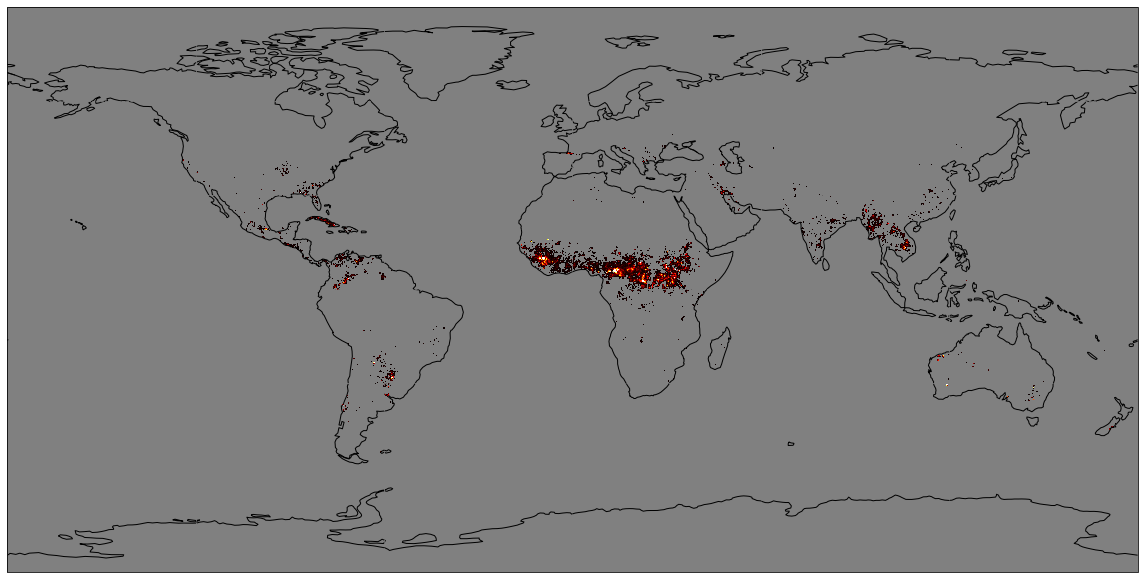

<function matplotlib.pyplot.close(fig=None)>

In [31]:
plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

ax.imshow(data, origin='lower', extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),cmap=cmap,vmin=0, vmax=100.0)

#plt.title('({}) VIIRS AF IBands {}-{}-{} / FP_PersistentAnomalyCategory = {} ({})'.format(platform,year,month,day,PersistentAnomalyCategory,FP_PersistentAnomalyCategory_Legend[PersistentAnomalyCategory]),fontsize=16)

plt.tight_layout()

plt.savefig("./outputs/Fire_Radiative_Power_Map.png", bbox_inches='tight', dpi=200)

plt.show()

plt.close

In [50]:
data = df_grid['4_Day'].to_numpy() / df_grid['Counts_Day'].to_numpy()

dim0 = int(180/0.1)
dim1 = int(360/0.1)

data = data.reshape((dim0,dim1))

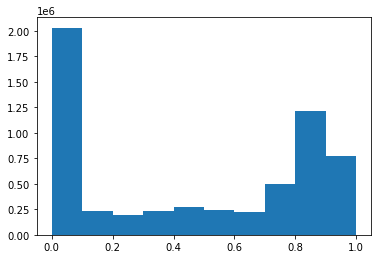

In [51]:
plt.hist(data.ravel())

plt.show()

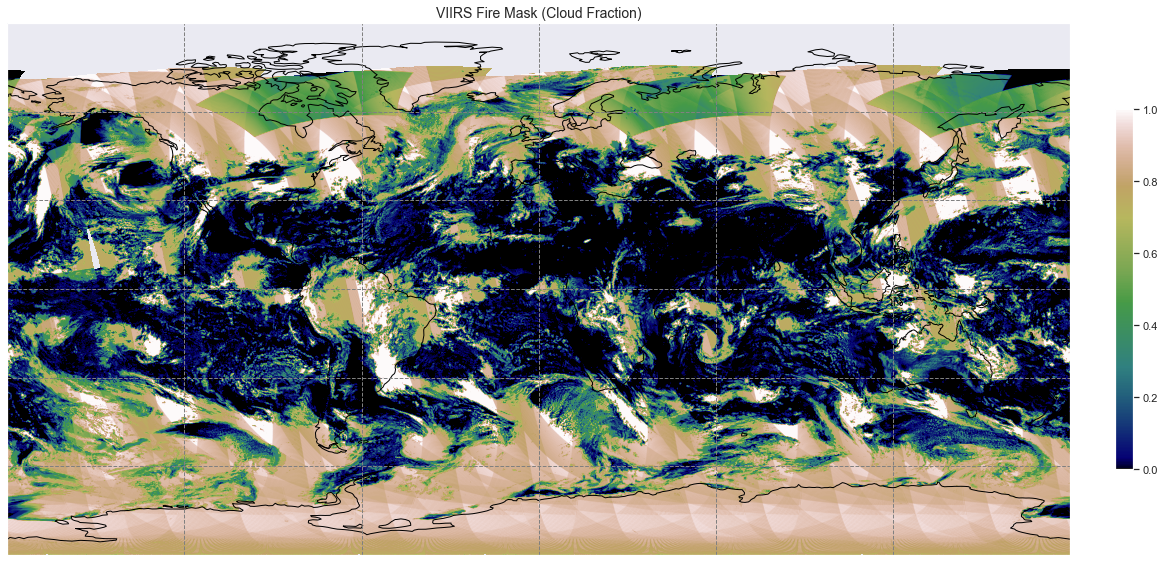

<function matplotlib.pyplot.close(fig=None)>

In [54]:
import seaborn as sns; sns.set()

plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

img = ax.imshow(data, origin='lower', extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),cmap=cm.gist_earth,vmin=0, vmax=1.0)

#plt.title('({}) VIIRS AF IBands {}-{}-{} / FP_PersistentAnomalyCategory = {} ({})'.format(platform,year,month,day,PersistentAnomalyCategory,FP_PersistentAnomalyCategory_Legend[PersistentAnomalyCategory]),fontsize=16)

plt.title('VIIRS Fire Mask (Cloud Fraction)',fontsize=14)

plt.tight_layout()

plt.colorbar(img, fraction=0.016, pad=0.04)

plt.savefig("./outputs/Fire_Radiative_Power_Map.png", bbox_inches='tight', dpi=200)

plt.show()

plt.close

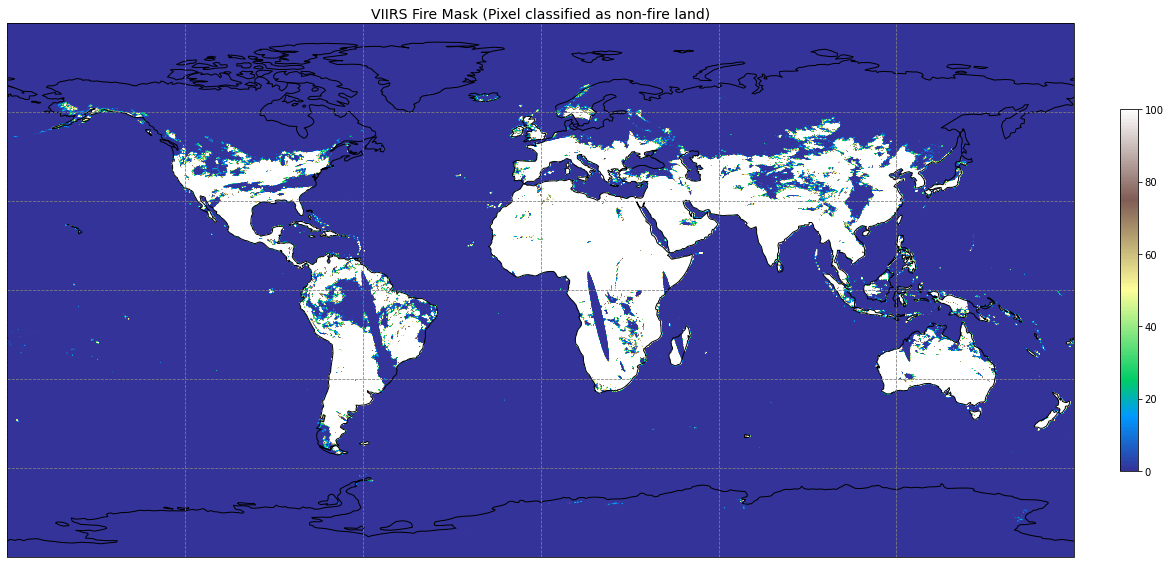

<function matplotlib.pyplot.close(fig=None)>

In [48]:
data = df_grid['5_Day'].to_numpy()

dim0 = int(180/0.1)
dim1 = int(360/0.1)

data = data.reshape((dim0,dim1))

plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

img = ax.imshow(data, origin='lower', extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),cmap=cm.terrain,vmin=0, vmax=100.0)

#plt.title('({}) VIIRS AF IBands {}-{}-{} / FP_PersistentAnomalyCategory = {} ({})'.format(platform,year,month,day,PersistentAnomalyCategory,FP_PersistentAnomalyCategory_Legend[PersistentAnomalyCategory]),fontsize=16)

plt.title('VIIRS Fire Mask (Pixel classified as non-fire land)',fontsize=14)

plt.tight_layout()

plt.colorbar(img, fraction=0.016, pad=0.04)

plt.savefig("./outputs/Fire_Radiative_Power_Map.png", bbox_inches='tight', dpi=200)

plt.show()

plt.close

## References

- [How to calculate the fraction in percent of a categorical variable using Pandas GroupBy ?](https://www.moonbooks.org/Articles/How-to-calculate-the-fraction-in-percent-of-a-categorical-variable-using-GroupBy-on-a-Pandas-DataFrame-/) 
- [How to merge two pandas dataframes and sum values of the shared columns ?](https://www.moonbooks.org/Articles/How-to-merge-two-pandas-dataframes-and-sum-values-of-the-shared-columns-/)